# Import delle librerie 

In [118]:
import tensorflow as tf
import tensorflow_datasets as tfds
from matplotlib import pyplot as plt
import numpy as np
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
import os
from tensorflow.keras.preprocessing.image import array_to_img
from tensorflow.keras.callbacks import Callback

In [119]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

In [120]:
# Use the tensorflow datasets api to bring in the data source
ds = tfds.load('fashion_mnist', split='train')
ds.as_numpy_iterator().next()['label']

2

# Visualizziamo i dati e creiamo il dataset

In [121]:
# vado a definire un iteratore 
dataiterator = ds.as_numpy_iterator()

# Andiamo a estrarre i dati dalla pipeline
dataiterator.next()['image']

array([[[  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [ 18],
        [ 77],
        [227],
        [227],
        [208],
        [210],
        [225],
        [216],
        [ 85],
        [ 32],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0]],

       [[  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [ 61],
        [100],
        [ 97],
        [ 80],
        [ 57],
        [117],
        [227],
        [238],
        [115],
        [ 49],
        [ 78],
        [106],
        [108],
        [ 71],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0]],

       [[  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [ 81],
        [105],
        [ 80],
        [ 69],
      

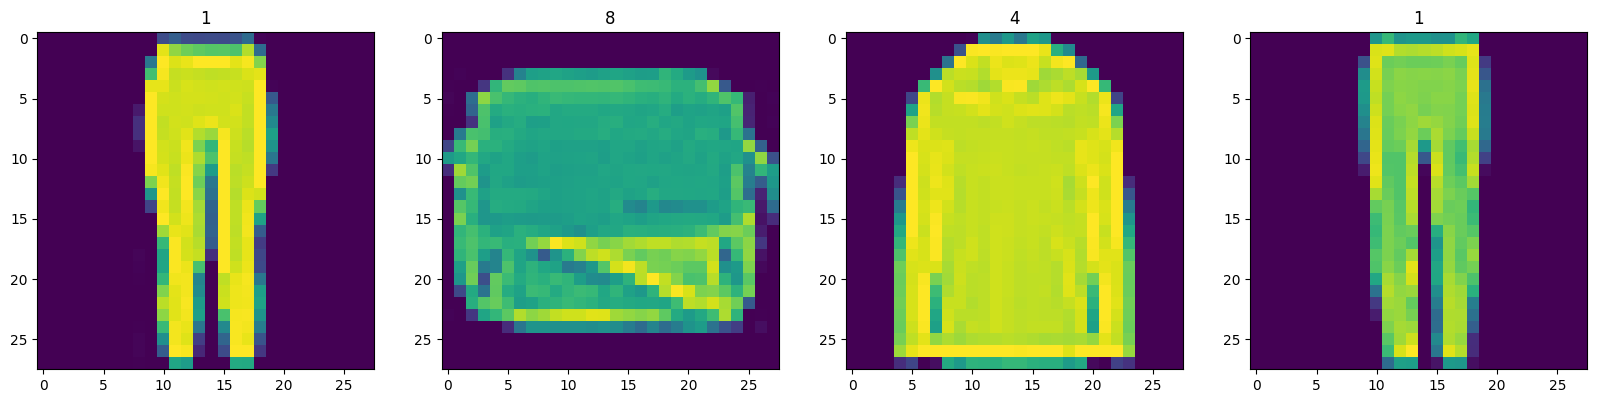

In [122]:
# Andiamo a settare il formato per il subplot
fig, ax = plt.subplots(ncols=4, figsize=(20,20))

# Andiamo a stampare le prime 4 immagini
for idx in range(4): 
    # Prendo un immagine e la sua label
    sample = dataiterator.next()

    # Faccio il plot dell'immagine
    ax[idx].imshow(np.squeeze(sample['image']))
    
    # Aggiungo la label dell'immagine come titolo
    ax[idx].title.set_text(sample['label'])

In [123]:
# Questa è una funziona che mi ritorna una immagine scalata
def scale_images(data): 
    image = data['image']
    return image / 255

In [124]:
# Ricarico il dataset
ds = tfds.load('fashion_mnist', split='train')

# Vado a creare un nuovo dataset di immagini a cui ho applicato la mia funzione di scalatura
ds = ds.map(scale_images)

# Salvo il dataset in cache
ds = ds.cache()

# Operazione di shuffle 
ds = ds.shuffle(60000)

# Divido in batch da 128 immagini
ds = ds.batch(128)

# Riduco la probabilità dei colli di bottiglia 
ds = ds.prefetch(64)

In [125]:
ds.as_numpy_iterator().next().shape

(128, 28, 28, 1)

# Costruisco la rete neurale 

In [126]:
# Prendo in sequenza le api per avere generatore e disciminatore
from tensorflow.keras.models import Sequential
# Prendo gli strati della rete neurale
from tensorflow.keras.layers import Conv2D, Dense, Flatten, Reshape, LeakyReLU, Dropout, UpSampling2D

# Costruiamo il generatore

In [127]:
def build_generator(): 
    model = Sequential()
    
    # Prende valori casuali e li rimodella nel formato 7x7x128
    # Inizio di un'immagine generata
    model.add(Dense(7*7*128, input_dim=128))
    model.add(LeakyReLU(0.2))
    model.add(Reshape((7,7,128)))
    
    # Upsampling block 1 
    model.add(UpSampling2D())
    model.add(Conv2D(128, 5, padding='same'))
    model.add(LeakyReLU(0.2))
    
    # Upsampling block 2 
    model.add(UpSampling2D())
    model.add(Conv2D(128, 5, padding='same'))
    model.add(LeakyReLU(0.2))
    
    # Convolutional block 1
    model.add(Conv2D(128, 4, padding='same'))
    model.add(LeakyReLU(0.2))
    
    # Convolutional block 2
    model.add(Conv2D(128, 4, padding='same'))
    model.add(LeakyReLU(0.2))
    
    # Conv layer to get to one channel
    model.add(Conv2D(1, 4, padding='same', activation='sigmoid'))
    
    return model

In [128]:
generator = build_generator()
generator.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_14 (Dense)            (None, 6272)              809088    
                                                                 
 leaky_re_lu_63 (LeakyReLU)  (None, 6272)              0         
                                                                 
 reshape_7 (Reshape)         (None, 7, 7, 128)         0         
                                                                 
 up_sampling2d_14 (UpSamplin  (None, 14, 14, 128)      0         
 g2D)                                                            
                                                                 
 conv2d_63 (Conv2D)          (None, 14, 14, 128)       409728    
                                                                 
 leaky_re_lu_64 (LeakyReLU)  (None, 14, 14, 128)       0         
                                                     

In [129]:
img = generator.predict(np.random.randn(4,128,1))

1/1 [==============================] - 0s 90ms/step


1/1 [==============================] - 0s 40ms/step


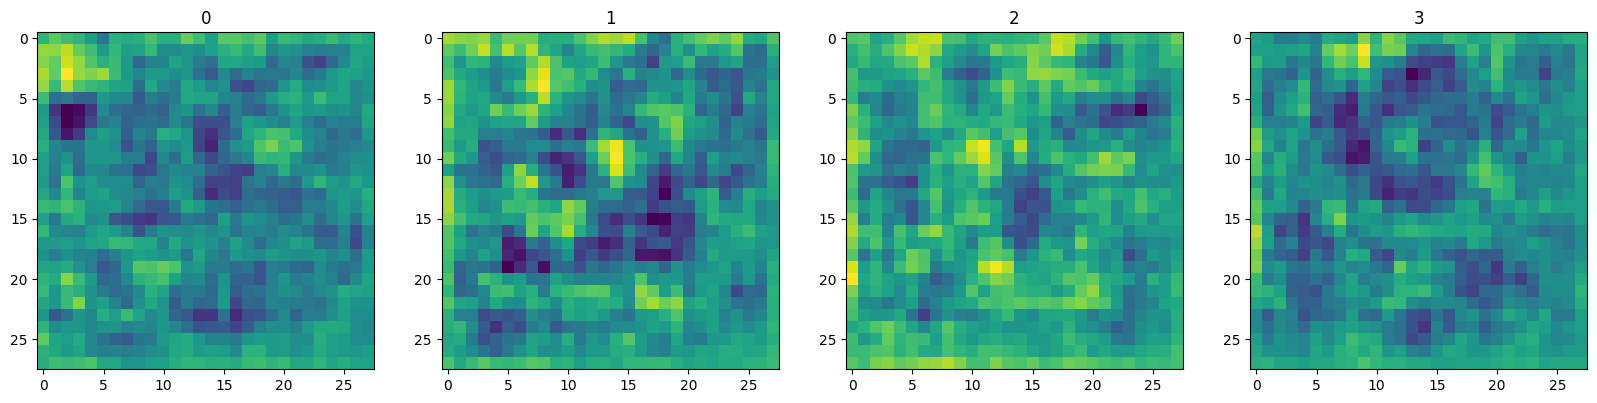

In [130]:
# Generiamo nuova moda
img = generator.predict(np.random.randn(4,128,1))

# Faccio un plot analogo a quello visto precedentemente
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, a in enumerate(img): 
    ax[idx].imshow(np.squeeze(a))
    ax[idx].title.set_text(idx)

# Costruisco il discriminatore

In [131]:
def build_discriminator(): 
    model = Sequential()
    
    # First Conv Block
    model.add(Conv2D(32, 5, input_shape = (28,28,1)))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))
    
    # Second Conv Block
    model.add(Conv2D(64, 5))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))
    
    # Third Conv Block
    model.add(Conv2D(128, 5))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))
    
    # Fourth Conv Block
    model.add(Conv2D(256, 5))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))
    
    # Appiattire per passare allo strato denso
    model.add(Flatten())
    model.add(Dropout(0.4))
    model.add(Dense(1, activation='sigmoid'))
    
    return model 

In [132]:
discriminator = build_discriminator()

discriminator.summary()

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_68 (Conv2D)          (None, 24, 24, 32)        832       
                                                                 
 leaky_re_lu_68 (LeakyReLU)  (None, 24, 24, 32)        0         
                                                                 
 dropout_35 (Dropout)        (None, 24, 24, 32)        0         
                                                                 
 conv2d_69 (Conv2D)          (None, 20, 20, 64)        51264     
                                                                 
 leaky_re_lu_69 (LeakyReLU)  (None, 20, 20, 64)        0         
                                                                 
 dropout_36 (Dropout)        (None, 20, 20, 64)        0         
                                                                 
 conv2d_70 (Conv2D)          (None, 16, 16, 128)     

In [133]:
img_test = img[0]

In [134]:
print(img_test.shape)
print(img.shape)

(28, 28, 1)
(4, 28, 28, 1)


In [135]:
discriminator.predict(img)

1/1 [==============================] - 0s 57ms/step


array([[0.50251716],
       [0.50244194],
       [0.5024858 ],
       [0.50250113]], dtype=float32)

# Andiamo a costruire il training loop

## Settiamo la loss e l'ottimizzatore

In [136]:
g_opt = Adam(learning_rate=0.0001) 
d_opt = Adam(learning_rate=0.00001) 
g_loss = BinaryCrossentropy()
d_loss = BinaryCrossentropy()

## Andiamo a creare una classe per il nostro modello

In [137]:
class FashionGAN(Model): 
    def __init__(self, generator, discriminator, *args, **kwargs):

        # Passiamo attraverso args e kwargs per arrivare alla superclasse 
        super().__init__(*args, **kwargs)
        
        # Creiamo gli attributi per generatore e discriminatore 
        self.generator = generator 
        self.discriminator = discriminator 
        
    def compile(self, g_opt, d_opt, g_loss, d_loss, *args, **kwargs): 

        # Compila con la super classe
        super().compile(*args, **kwargs)
        
        # Creiamo gli attributi per losses and optimizers
        self.g_opt = g_opt
        self.d_opt = d_opt
        self.g_loss = g_loss
        self.d_loss = d_loss 

    def train_step(self, batch):

        # Prenidamo i dati
        real_images = batch
        fake_images = self.generator(tf.random.normal((128, 128, 1)), training=False)
        
        # Addestriamo il discriminatore 
        with tf.GradientTape() as d_tape: 
            # Passiamo immagini reali e fake al discriminatore 
            yhat_real = self.discriminator(real_images, training=True) 
            yhat_fake = self.discriminator(fake_images, training=True)
            yhat_realfake = tf.concat([yhat_real, yhat_fake], axis=0)
            
            # Creiamo delle label per immagini reali e fake
            y_realfake = tf.concat([tf.zeros_like(yhat_real), tf.ones_like(yhat_fake)], axis=0)
            
            # Aggiungiamo un pò di rumore alle immagini vere
            noise_real = 0.15*tf.random.uniform(tf.shape(yhat_real))
            noise_fake = -0.15*tf.random.uniform(tf.shape(yhat_fake))
            y_realfake += tf.concat([noise_real, noise_fake], axis=0)
            
            # Calcoliamo loss - BINARYCROSS 
            total_d_loss = self.d_loss(y_realfake, yhat_realfake)
            
        # Applichiamo la backpropagation - nn learn 
        dgrad = d_tape.gradient(total_d_loss, self.discriminator.trainable_variables) 
        self.d_opt.apply_gradients(zip(dgrad, self.discriminator.trainable_variables))
        
        # Addestriamo il generatore 
        with tf.GradientTape() as g_tape: 
            # Generiamo nuove immagini
            gen_images = self.generator(tf.random.normal((128,128,1)), training=True)
                                        
            # Create the predicted labels
            predicted_labels = self.discriminator(gen_images, training=False)
                                        
            # Calcoliamo la loss - trick per addestrare il modello a ingannare il discriminatore 
            total_g_loss = self.g_loss(tf.zeros_like(predicted_labels), predicted_labels) 
            
        # Applichiamo la backprop
        ggrad = g_tape.gradient(total_g_loss, self.generator.trainable_variables)
        self.g_opt.apply_gradients(zip(ggrad, self.generator.trainable_variables))
        
        return {"d_loss":total_d_loss, "g_loss":total_g_loss}

In [138]:
# Creo un'istanza della classe

fashgan = FashionGAN(generator, discriminator)

In [139]:
# Compilo il modello 

fashgan.compile(g_opt, d_opt, g_loss, d_loss)

## Costruiamo la callback

In [140]:
class ModelMonitor(Callback):
    def __init__(self, num_img=3, latent_dim=128):
        self.num_img = num_img
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
        random_latent_vectors = tf.random.uniform((self.num_img, self.latent_dim,1))
        generated_images = self.model.generator(random_latent_vectors)
        generated_images *= 255
        generated_images.numpy()
        for i in range(self.num_img):
            img = array_to_img(generated_images[i])
            img.save(os.path.join('images', f'generated_img_{epoch}_{i}.png'))

# Fase di training del modello

In [141]:
hist = fashgan.fit(ds, epochs=20, callbacks=[ModelMonitor()])

Epoch 1/20
 34/469 [=>............................] - ETA: 43:59 - d_loss: 0.6933 - g_loss: 0.6936

KeyboardInterrupt: 

# Esaminiamo le performance

In [ ]:
plt.suptitle('Loss')
plt.plot(hist.history['d_loss'], label='d_loss')
plt.plot(hist.history['g_loss'], label='g_loss')
plt.legend()
plt.show()

# Generiamo delle immagini 

In [ ]:
generator.load_weights(os.path.join('archive', 'generatormodel.h5'))

In [ ]:
imgs = generator.predict(tf.random.normal((16, 128, 1)))

In [ ]:
fig, ax = plt.subplots(ncols=4, nrows=4, figsize=(10,10))
for r in range(4): 
    for c in range(4): 
        ax[r][c].imshow(imgs[(r+1)*(c+1)-1])

# Salviamo i modelli

In [ ]:
generator.save('generator.h5')
discriminator.save('discriminator.h5')